In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [20]:
data_to_cluster = pd.read_csv("Данные/processed/clustering-data-douglas.csv")
# data_to_cluster.iloc[11]
# data_to_cluster = data_to_cluster.drop([11])
data_to_cluster

,Код раздела,Название раздела,ROFA,K,L
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.028444,1.265974e+07,1.613248e+08
1,B,Добыча полезных ископаемых,0.019001,4.200038e+07,1.086961e+08
2,C,Обрабатывающие производства,0.029081,4.013153e+07,4.696099e+08
3,D,"Обеспечение электрической энергией, газом и па...",0.008164,2.925099e+07,8.481285e+07
4,E,"Водоснабжение; водоотведение, организация сбор...",0.007181,5.519033e+06,2.576581e+07
5,F,Строительство,0.111577,4.599606e+06,2.906785e+08
6,G,Торговля оптовая и розничная; ремонт автотранс...,0.161386,7.363812e+06,5.740944e+08
7,H,Транспортировка и хранение,0.007310,8.276302e+07,2.935739e+08
8,I,Деятельность гостиниц и предприятий общественн...,0.027953,2.738810e+06,5.212317e+07
9,J,Деятельность в области информации и связи,0.026328,8.944900e+06,1.284029e+08


In [21]:
data_to_cluster = data_to_cluster.drop(columns=[ "Название раздела"])
data_to_cluster = data_to_cluster.groupby("Код раздела", as_index=False).mean()

In [22]:
X = data_to_cluster.drop(columns=[ "Код раздела", "ROFA"])
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X[:5]

array([[0.06798103, 0.24722218],
       [0.26903138, 0.15124201],
       [0.25622549, 0.80944921],
       [0.18166893, 0.10768551],
       [0.01905087, 0.        ]])

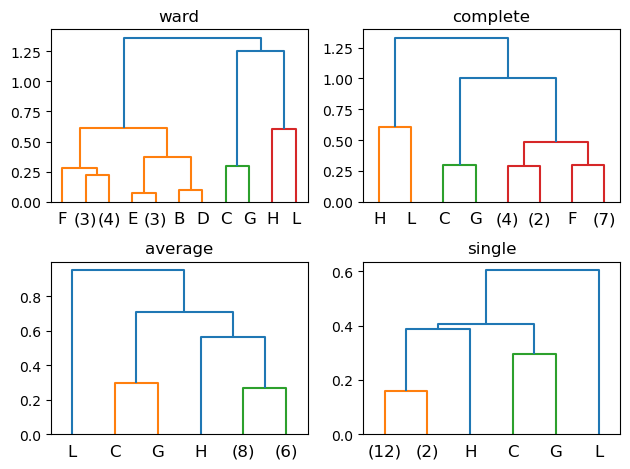

In [23]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

linkage_types = ['ward', 'complete', 'average', 'single']
cutoff_thresholds = [1, 0.7, 0.5, 0.35]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))

hclust = dict()
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    clustering = AgglomerativeClustering(linkage=linkage_type, 
                                         distance_threshold=0,
                                         n_clusters=None).fit(X)
    axs[axs_ind].set_title(linkage_type)
    linkage_matrix = plot_dendrogram(
        clustering,
        truncate_mode="level",
        p=3,
        ax=axs[axs_ind], 
        labels=data_to_cluster["Код раздела"].to_list(),
        color_threshold = linkage_colors[linkage_type]
        # orientation='right'
        )
    hclust[linkage_type] = {
        "clustering": clustering,
        "linkage_matrix": linkage_matrix
    }
fig.tight_layout()

In [24]:
cluster_mapping = data_to_cluster.loc[:, :"Код раздела"]
cluser_count = []
for linkage_type, threshold in zip(linkage_types, cutoff_thresholds):
    enum = fcluster(hclust[linkage_type]["linkage_matrix"], t=threshold, criterion='distance')
    model = hclust[linkage_type]["clustering"]
    # hclust[linkage_type]["score"] = metrics.silhouette_score(X, enum, metric='euclidean')
    cluster_mapping.loc[:, linkage_type] = pd.Series(enum)
    cluser_count.append(cluster_mapping.nunique()[linkage_type])
# cluster_mapping.head()
cluser_count

[3, 3, 4, 4]

In [25]:
data_clustered = pd.merge(data_to_cluster, cluster_mapping, 'inner', "Код раздела")
data_clustered.to_csv('Данные/processed/clustering-douglas.csv', index=False) 

In [26]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [27]:
data_clustered[( data_clustered["K"] > 0.5 * 10**8 ) & ( data_clustered["K"] < 1 * 10**8 )]

,Код раздела,ROFA,K,L,ward,complete,average,single
7,H,0.00731,8.276302e+07,2.935739e+08,3,1,3,2


In [28]:
data_for_regr = pd.read_csv('Данные/processed/regression-data-v0.csv')
data_for_regr.head()

,Код раздела,Название раздела,ROFA,K,L,t
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.033481,9966787,1.302680e+08,2017
1,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.030218,11231579,1.416755e+08,2018
2,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.031950,10989834,1.516897e+08,2019
3,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.028979,12137603,1.583287e+08,2020
4,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.024977,13966128,1.770949e+08,2021


In [29]:
data_for_regr.loc[:, "ROFA":"t"]

,ROFA,K,L,t
0,0.033481,9966787,1.302680e+08,2017
1,0.030218,11231579,1.416755e+08,2018
2,0.031950,10989834,1.516897e+08,2019
3,0.028979,12137603,1.583287e+08,2020
4,0.024977,13966128,1.770949e+08,2021
...,...,...,...,...
103,0.016265,4860149,5.106041e+07,2018
104,0.013415,5941944,5.339049e+07,2019
105,0.012070,5884152,5.397742e+07,2020
106,0.011450,7161180,6.106398e+07,2021


In [ ]:
data_for_regr_cl = pd.merge(data_for_regr, cluster_mapping, 'inner', "Код раздела")
data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
data_for_regr_cl.to_csv("Данные/processed/regression-data-log-ward-v1.csv", index=False)
data_for_regr_cl.groupby('ward').count()

,Код раздела,Название раздела,ln_ROFA,ln_K,ln_L,t,complete,average,single
ward,,,,,,,,,
1,24,24,24,24,24,24,24,24,24
2,18,18,18,18,18,18,18,18,18
3,24,24,24,24,24,24,24,24,24
4,42,42,42,42,42,42,42,42,42


In [ ]:
linkage_type = 'ward'
regr_metrics_all = []
for cluster_id in data_for_regr_cl[linkage_type].unique():
    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]
    data_for_regr_cl[data_for_regr_cl['ward'] == cluster_id]

    regr_metrics = {}
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    # if cluster_id == 2:
    #     result_OLS = regression.fit_regularized(alpha=0, L1_wt=0)
    # else:
    result_OLS = regression.fit()

    n=X[X.columns[0]].count()
    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['obs_count'] = n

    regr_metrics['shapiro-wilk'] = stats.shapiro(result_OLS.resid).pvalue
    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]

    white_res = sm.stats.diagnostic.het_white(result_OLS.resid, regression.exog)
    white_lm_pvalue = white_res[1]
    regr_metrics['white_lm_pvalue'] = white_lm_pvalue

    dw = sm.stats.stattools.durbin_watson(result_OLS.resid)
    regr_metrics['D-W'] = dw

    VIF_array = []
    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        VIF_array.append(round(VIF, 2))
        regr_metrics[f'VIF_x{exog_idx}'] = VIF
    # print('-- VIF:', VIF_array)
    hz, hz_pval, normal = multivariate_normality(regression.exog)
    regr_metrics['HZ'] = hz_pval
    regr_metrics_all.append(regr_metrics)

    print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
    print(result_OLS.summary())    
    print('-- White\'s test pvalue: ', white_lm_pvalue)
    print('-- VIF:', VIF_array)

    X_resid = X.iloc[:, 1:]
    X_resid = X_resid.join(pd.DataFrame({"e": result_OLS.resid}))
    X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"], hue='Код раздела', height=4)
    # g.map(sns.regplot, color=".3", ci=None)
    g.map(sns.scatterplot)
    g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

pd.reset_option('display.precision')
regr_metrics_all = pd.DataFrame(regr_metrics_all)
# print(regr_metrics_all)
regr_metrics_all.sort_values(by='cluster_id')
# plt.show()

# CHECK HETEROSCEDASTISITY


Linkage: ward, cluster 3, n: 24
                            OLS Regression Results                            
Dep. Variable:                ln_ROFA   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     87.75
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           1.10e-11
Time:                        21:56:25   Log-Likelihood:                 2.9892
No. Observations:                  24   AIC:                             2.022
Df Residuals:                      20   BIC:                             6.734
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -92.02

,cluster_id,obs_count,shapiro-wilk,JB,white_lm_pvalue,D-W,VIF_x1,VIF_x2,VIF_x3,HZ
3,1,24,0.71,0.68,0.03,0.59,1.11,1.14,1.09,0.00
1,2,18,0.02,0.29,0.11,1.01,28.89,28.86,1.03,0.00
0,3,24,0.03,0.33,0.07,0.33,1.60,1.17,1.75,0.00
2,4,42,0.06,0.27,0.00,0.38,1.18,1.20,1.10,0.00



Linkage: ward, cluster 1, n: 84
                            OLS Regression Results                            
Dep. Variable:                ln_ROFA   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     79.05
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           7.39e-24
Time:                        20:57:04   Log-Likelihood:                -38.207
No. Observations:                  84   AIC:                             84.41
Df Residuals:                      80   BIC:                             94.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        210.34

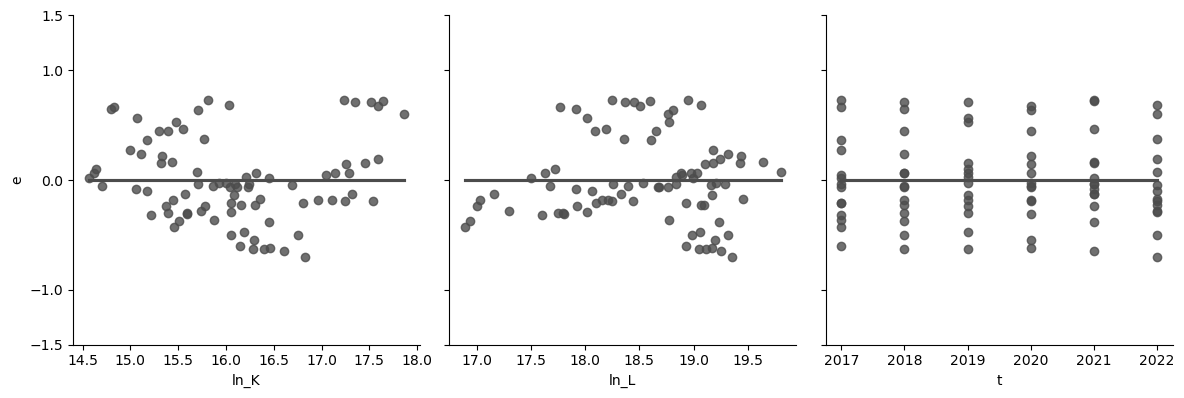

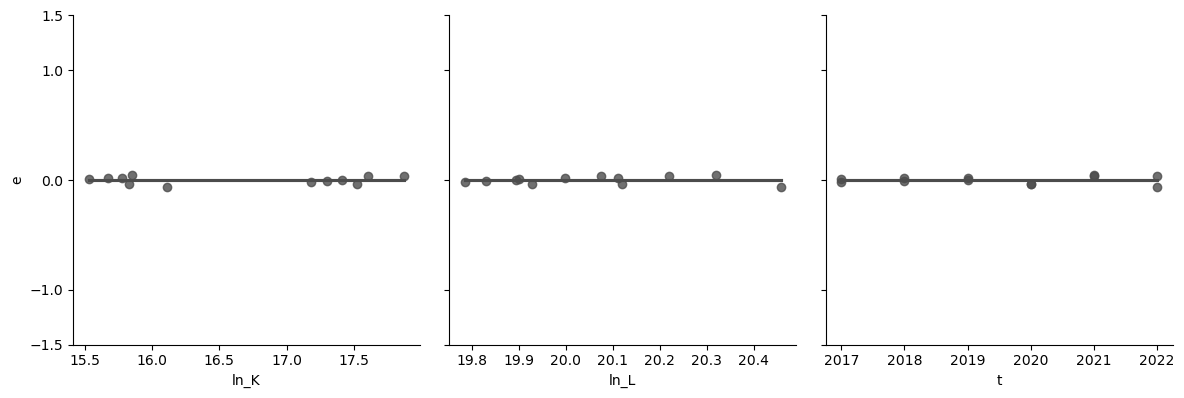

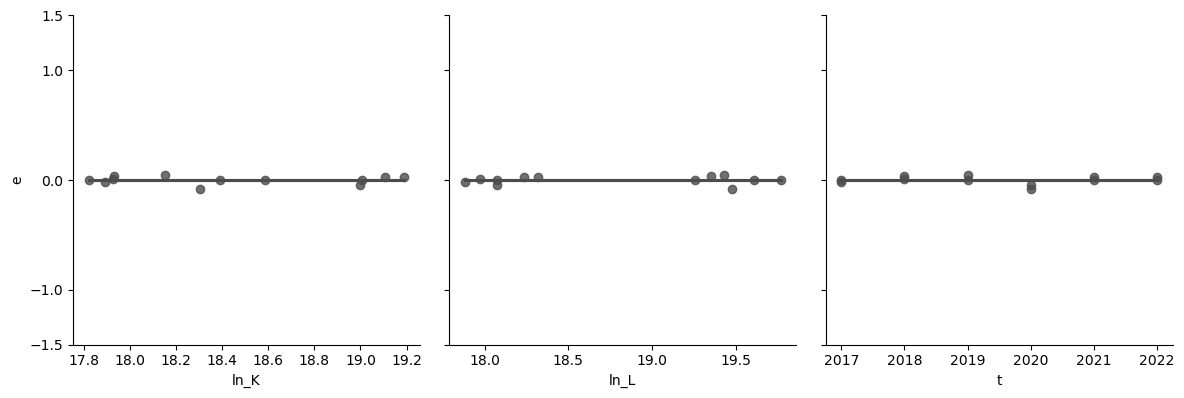

In [30]:
linkage_type = 'ward'
for cluster_id in data_for_regr_cl[linkage_type].unique():
    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()
    print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=X[X.columns[0]].count()))
    print(result_OLS.summary())
    white_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    print('-- White\'s test pvalue: ', white_pvalue)

    X_resid = X.iloc[:, 1:]
    X_resid = X_resid.join(pd.DataFrame({"e": result_OLS.resid}))
    g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"], height=4)
    g.map(sns.regplot, color=".3", ci=None)
    g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

In [31]:
data_for_ANOVA = pd.merge(cluster_mapping, data_for_regr.loc[:, ["Код раздела", "ROFA"]], 'inner', 'Код раздела')
for linkage_type in linkage_types:
    groups = []
    for group_id in data_for_ANOVA[linkage_type].unique():
        groups.append(data_for_ANOVA["ROFA"][(data_for_ANOVA[linkage_type] == group_id)].to_numpy())
    res = stats.bartlett(*groups)
    print('bartlett', res.pvalue)
    res = stats.kruskal(*groups)
    print('kruskal', res.pvalue)

bartlett 2.183062750790432e-14
kruskal 4.27456190038973e-08
bartlett 2.183062750790432e-14
kruskal 4.27456190038973e-08
bartlett 6.660820085856594e-13
kruskal 2.039660084835903e-07
bartlett 6.660820085856594e-13
kruskal 2.039660084835903e-07
